# Test Audio Sender

This file is used for sending audio data to the device. It measures the accuracy based on individual audio files.

**Note that the software on the MCU must match this!**

In [170]:
AUDIO_FOLDER_PATH = "dataset_speed_test"
POSITIVE_PATH = f"{AUDIO_FOLDER_PATH}/Positive"
NEGATIVE_PATH = f"{AUDIO_FOLDER_PATH}/Negative"

In [171]:
import numpy as np
import pandas as pd
import gc
import os
import librosa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import serial
import struct

In [172]:
# Collecte positive audio files and their classes
positive_audio_files = []
positive_audio_file_classes = []
# Look each file in the audio folder
audio_class_folders = os.listdir(POSITIVE_PATH)
# Loop each class folder
for audio_class_folder in audio_class_folders:
    # Assemble full audio class folder path.
    audio_class_folder_path = os.path.join(POSITIVE_PATH, audio_class_folder)
    print("Processing class folder: ", audio_class_folder_path)
    # Get all files in the audio class folder
    audio_class_files = os.listdir(audio_class_folder_path)
    # Loop each audio file in the audio class folder
    for audio_class_file in audio_class_files:
        # Assemble full audio file path.
        audio_file_path = os.path.join(audio_class_folder_path, audio_class_file)
        # Append the audio file path to the positive_audio_files list
        positive_audio_files.append(audio_file_path)
        # Append the audio class to the audio_file_classes list
        positive_audio_file_classes.append(audio_class_folder)
print("positive_audio_files length: ", len(positive_audio_files))
print("positive_audio_file_classes length: ", len(positive_audio_file_classes))

Processing class folder:  dataset_speed_test/Positive/Car
Processing class folder:  dataset_speed_test/Positive/Comm
Processing class folder:  dataset_speed_test/Positive/Motorcycle
positive_audio_files length:  935
positive_audio_file_classes length:  935


In [173]:
positive_audio_file_classes[0]

'Car'

In [174]:
# Collecte negative audio files and their classes
negative_audio_files = []
negative_audio_file_classes = []
# Look each file in the audio folder
audio_class_folders = os.listdir(NEGATIVE_PATH)
# Loop each class folder
for audio_class_folder in audio_class_folders:
    # Assemble full audio class folder path.
    audio_class_folder_path = os.path.join(NEGATIVE_PATH, audio_class_folder)
    print("Processing class folder: ", audio_class_folder_path)
    # Get all files in the audio class folder
    audio_class_files = os.listdir(audio_class_folder_path)
    # Loop each audio file in the audio class folder
    for audio_class_file in audio_class_files:
        # Assemble full audio file path.
        audio_file_path = os.path.join(audio_class_folder_path, audio_class_file)
        # Append the audio file path to the negative_audio_files list
        negative_audio_files.append(audio_file_path)
        # Append the audio class to the audio_file_classes list
        negative_audio_file_classes.append(audio_class_folder)
print("negative_audio_files length: ", len(negative_audio_files[0:10]))
print("negative_audio_file_classes length: ", len(negative_audio_file_classes[0:10]))

Processing class folder:  dataset_speed_test/Negative/Background
negative_audio_files length:  10
negative_audio_file_classes length:  10


In [175]:
# Shuffle the audio files and classes with the same seed.
seed = 42
np.random.seed(seed)
np.random.shuffle(positive_audio_files)

np.random.seed(seed)
np.random.shuffle(positive_audio_file_classes)

np.random.seed(seed)
np.random.shuffle(negative_audio_files)

In [176]:
# Hot end code the labels.
label_encoder = LabelEncoder()
positive_audio_file_classes_categorical = to_categorical(label_encoder.fit_transform(positive_audio_file_classes))
print("Example of audio_file_classes_categorial: ", positive_audio_file_classes_categorical[0:10])

Example of audio_file_classes_categorial:  [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [177]:
# Print labels and their corresponding numbers
labels = label_encoder.classes_
print("Labels and their corresponding numbers:")
for i, label in enumerate(labels):
    print(f"{i}: {label}")

Labels and their corresponding numbers:
0: Car
1: Comm
2: Motorcycle


In [178]:
# Connect to MCU via serial.
print("Configuring serial port...")
ser = serial.Serial(
    port='/dev/ttyACM0',  # Change this to your actual port, e.g., 'COM3' on Windows, '/dev/ttyS0' on Linux
    baudrate=921600,       # Set baud rate to 921600
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=0.1,           # Set timeout for reading
    write_timeout=None     # Wait indefinitely until all data is sent
)

Configuring serial port...


In [179]:
if ser.is_open:
    print(f"Serial port {ser.port} opened at {ser.baudrate} baud.")

Serial port /dev/ttyACM0 opened at 921600 baud.


In [180]:
(np.array([0,1,2,3]) + 1) % 4

array([1, 2, 3, 0])

In [181]:
def calc_accuracy(realResults, results):
    correct = 0
    tmpRes = [((i - 1) % 4) if i != 9 else 9 for i in results]
    total = min(len(realResults), len(tmpRes))  # Ensure we only compare up to the shorter length
    for real, predicted in zip(realResults[:total], tmpRes[:total]):
        if real == predicted:
            correct += 1
    return correct / total if total > 0 else 0.0

import numpy as np

def confusion_matrix_manual(y_true, y_pred):

    labels = sorted(set(y_true + y_pred))  # All unique labels
    matrix = {label: {l: 0 for l in labels} for label in labels}

    for real, pred in zip(y_true, y_pred):
        matrix[real][pred] += 1

    return matrix


def print_confusion_matrix(cm):
    labels = list(cm.keys())
    print("    " + " ".join(f"{l:>4}" for l in labels))
    for real in labels:
        row = " ".join(f"{cm[real][pred]:>4}" for pred in labels)
        print(f"{real:>4} {row}")

In [182]:
audioSent = 0
audioFilesProcessed = 0
results = []
realResults = []

In [183]:
positive_audio_file_classes_categorical[0]

array([1., 0., 0.])

In [184]:
def streamAudioFile(file_path, realClass, i):
    global audioSent
    global results
    global realResults
    global audioBuffer

    # Append the real result to the results list.
    realResults.append(np.argmax(realClass))

    # Check file format.
    if not file_path.endswith('.wav'):
        print("Error: Only .wav files are supported.")
        return

    # Load the audio file.
    audio_data, sr = librosa.load(file_path, sr=None)

    # Convert sample rate to 16kHz.
    if sr != 16000:
        audio_data = librosa.resample(y=audio_data, orig_sr=sr, target_sr=16000)
        sr = 16000

    # Convert the audio data to a numpy array.
    audio_data = np.array(audio_data, dtype=np.float32)

    # Send the audio data to the MCU.
    ser.write(audio_data.tobytes())
    #if (np.argmax(realClass) == 4):
    #    ser.write(audio_data.tobytes())

    classifications = []

    while ser.in_waiting > 0:
        response = ser.readline().decode('utf-8').strip()
        if response.startswith("fin:"):
            matrix = confusion_matrix_manual(realResults, results)
            print_confusion_matrix(matrix)
        if response.startswith("e:"):
            print(response)
            return
        if response.startswith("c:"):
            print(response)
        if response.startswith("s:"):
            print(response)
        if response.startswith("v:"):
            print(response)
            response = int(response[2:])
            classifications.append(response)

    replaced = False
    if len(results) > 0:
        if results[-1] == 9:
            if (len(classifications) > 0):
                results[-1] = classifications.pop(0)
                replaced = True

    if len(classifications) > 0:
        results.append(classifications.pop(0))
        if replaced:
            realResults.append(realResults[-1])

    while len(classifications) > 0:
        results.append(classifications.pop(0))
        realResults.append(realResults[-1])
    
    # If no classification was received, append None to results.
    if i > 0 and len(results) < len(realResults):
        results.append(9)
    print(f"Accuracy: {calc_accuracy(realResults, results)}")

In [185]:

total_negative_audio_files = len(negative_audio_files)

# Loop each audio file.
negative_audio_file_pointer = 0
for i in range(total_negative_audio_files):
    # Get audio file path.
    audio_file = positive_audio_files[i]
    # Print audio file path and class.
    print("Processing audio file: ", audio_file)
    print("Processing audio file class: ", positive_audio_file_classes[i])
    # Stream positive audio file to MCU.
    streamAudioFile(audio_file, positive_audio_file_classes_categorical[i], i)
    # Print nagtive audio file path and class.
    print("Processing negative audio file: ", negative_audio_files[negative_audio_file_pointer])
    # Stream negative audio file to MCU.
    streamAudioFile(negative_audio_files[negative_audio_file_pointer], [0,0,0,1], i)
    # Increment the negative audio file pointer.
    negative_audio_file_pointer = (negative_audio_file_pointer + 1) % len(negative_audio_files)
    print(i, " of ", total_negative_audio_files)

Processing audio file:  dataset_speed_test/Positive/Car/2019-11-19-07-25_Langewiesener-Strasse_50Kmh_833024_M_D_CR_SE_CH34.wav
Processing audio file class:  Car
s:Heap: 1096 / 469792 bytes
s:Tensor arena size: 16672/37000 bytes
s:Input tensor shape: 1, 16, 8, 1
s:Output tensor shape: 1, 4
c: [-128,119,-119,-128] voted for: 1 max value: 119
c: [-256,153,-153,-256] voted for: 1 max value: 34
c: [-384,229,-229,-384] voted for: 1 max value: 76
c: [-512,356,-357,-512] voted for: 1 max value: 127
c: [-640,442,-443,-640] voted for: 1 max value: 86
c: [-768,442,-443,-768] voted for: 1 max value: 0
c: [-896,569,-570,-896] voted for: 1 max value: 127
Accuracy: 0.0
Processing negative audio file:  dataset_speed_test/Negative/Background/2019-11-19-07-25_Langewiesener-Strasse_50Kmh_66057600_SE_CH34-BG.wav
c: [-1023,680,-682,-1024] voted for: 1 max value: 111
c: [-896,552,-810,-1152] voted for: 0 max value: 127
c: [-769,424,-938,-1280] voted for: 0 max value: 127
c: [-642,296,-1066,-1408] voted for:

KeyboardInterrupt: 

In [ ]:
print(len([((i - 1) % 4) if i != 9 else 9 for i in results]))
print(len(realResults))

1652
1652


In [ ]:
print([((i - 1) % 4) if i != 9 else 9 for i in results])
print(list(map(int, realResults)))

#[1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 9, 9, 2, 9, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0]
#[1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 2, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1]

[0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 9, 9, 9, 9, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 9, 9, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 9, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 2, 3, 

In [ ]:
# Close the serial port
ser.close()

In [ ]:
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [ ]:
def printConfusionMatrix(results, realResults, labels_set):
    # Ensure that the inputs are numpy arrays
    results = np.array([((i - 1) % 4) if i != 9 else 9 for i in results])
    realResults = np.array(realResults)

    # Print the shapes of the arrays
    print(f"results: {results.shape}")
    print(f"realResults: {realResults.shape}")

    # Generate confusion matrix
    cm = confusion_matrix(realResults, results)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Visualize the normalized confusion matrix with proper labels
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels_set, yticklabels=labels_set)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


results: (1652,)
realResults: (1652,)


/tmp/ipykernel_19762/888203394.py:14: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


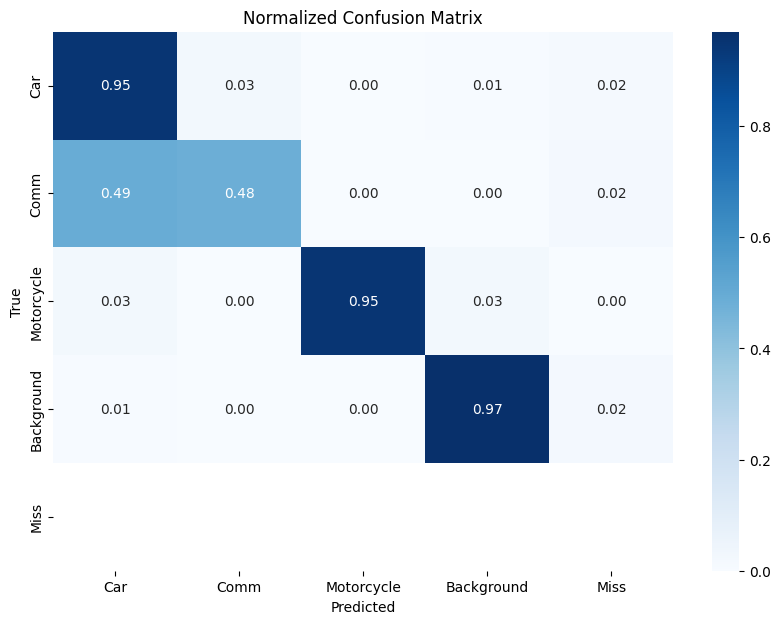

In [ ]:
printConfusionMatrix(results, realResults, ["Car", "Comm", "Motorcycle", "Background", "Miss"])